In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_10_mixup_ls")' FastaiNotebook_10_mixup_ls

Installing packages:
	.package(path: "/home/saeta/fastai_docs/dev_swift/FastaiNotebook_10_mixup_ls")
		FastaiNotebook_10_mixup_ls
With SwiftPM flags: []
Working in: /tmp/tmpi1s5nihp/swift-install
[1/2] Compiling jupyterInstalledPackages jupyterInstalledPackages.swift
[2/3] Merging module jupyterInstalledPackages
Initializing Swift...
Installation complete!


In [ ]:
import Foundation
import TensorFlow
import FastaiNotebook_10_mixup_ls
import Path

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## Laying the groundwork

### Downloading the data

In [ ]:
// hardcoded, should really generalise
public func downloadSpeakers(path: Path = dataPath) -> Path {
    let url = "http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz"
    let fname = "ST-AEDS-20180100_1-OS"
    let outDir = path/fname
    let outFile = path/"\(fname).tgz"
    try! outDir.mkdir(.p)
    if !outFile.exists {
        downloadFile(url, dest:outFile.string)
        _ = "/bin/tar".shell("-xzf", outFile.string, "-C", outDir.string)
    }
    print(outDir, type(of: outDir))
    return outDir
}

In [ ]:
let path = downloadSpeakers()

/home/saeta/.fastai/data/ST-AEDS-20180100_1-OS Path


### Opening WAVs in TensorFlow

Luckily, TensorFlow has a "decodeWav" function. Let's extend the StringTensor to provide swifty access to this function, the same way we did with JPGs.

In [ ]:
public extension StringTensor {
    // Decode a StringTensor holding a path to a WAV file into (audio: Tensor<Float>, sampleRate: Tensor<Int32>)
    func decodeWav() -> (audio: Tensor<Float>, sampleRate: Tensor<Int32>) {
        return Raw.decodeWav(contents: self)
    }
}

### Single example file

In [ ]:
let wav = path.ls()[0].path.string
print(wav)

/home/saeta/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00056.wav


In [ ]:
let (sig, sr) = StringTensor(readFile: wav).decodeWav()

### To Spectrogram

Luckily, TensorFlow has a couple of basic signal ops, including to Spectrogram.

In [ ]:
let spec = Raw.audioSpectrogram(sig, 
                                windowSize: 1024, stride: 256, magnitudeSquared: false)

Utility to look at a spectrogram. Note the axes don't line up with what you'd expect from a typical spectrogram - here the X axis is frequency and the Y axis is time.

In [ ]:
func showSpec(s: Tensor<Float>) {
    plt.imshow(s.makeNumpyArray()[0], cmap: "plasma")
    plt.show()
    print("Shape: \(s.shape)\nMin:\(s.min()), max: \(s.max()), mean: \(s.mean()), var: \(s.variance())")
}

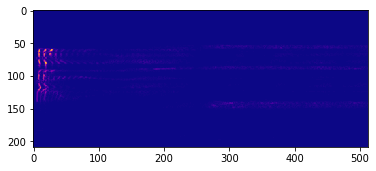

Shape: [1, 209, 513]
Min:1.2907397e-05, max: 16.511257, mean: 0.076232545, var: 0.15422489


In [ ]:
showSpec(s: spec)

### To MFCCs

Note that MFCCs are different from melspectrograms. It seems TF doesn't have a melspectrogram transform built-in. MFCCs at least have been used before so it doesn't seem crazy to use them instead, although they are generally used to intentionally reduce the dimensionality of the data, so we might be throwing away info that the NN could use. On the other hand we might be making it easier for the NN to find features it would've had to spend time finding itself. We'll give it a shot. On the plus side, it means much "smaller images".

[TF defaults](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/ops/audio_ops.cc#L147) for MFCCs:
```
    .Attr("upper_frequency_limit: float = 4000")
    .Attr("lower_frequency_limit: float = 20")
    .Attr("filterbank_channel_count: int = 40")
    .Attr("dct_coefficient_count: int = 13")
```

In [ ]:
let mfccs = Raw.mfcc(spectrogram: spec, sampleRate: sr, 
                       upperFrequencyLimit: 8000, lowerFrequencyLimit: 20, 
                       filterbankChannelCount: 40, dctCoefficientCount: 13)

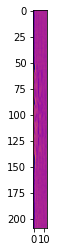

Shape: [1, 209, 13]
Min:-8.186757, max: 13.762619, mean: -0.015072358, var: 4.264482


In [ ]:
showSpec(s: mfccs)

## Using fastai - datablocks, labelers, splitters etc.

In [ ]:
let il = ItemList(fromFolder: path, extensions: ["wav", "WAV"])

In [ ]:
// export
public func randomSplitter(fName: Path, val_pct: Float) -> Bool {
    return Float.random(in: 0.0...1.0) < val_pct
}

In [ ]:
let sd = SplitData(il) { randomSplitter(fName: $0, val_pct: 0.2) }

We need a RegexLabeler. In python this was
```python
def re_labeler(fn, pat): return re.findall(pat, str(fn))[0]
```

In [ ]:
public func reLabeler(_ fName: Path, pat: String) -> String {
    // Gotta slice the input using the found range, then cast that `Substring` to `String`
    // Seems too clunky to be true but it does work
    // Needs a guard if re doesn't match
    return String(fName.string[fName.string.findFirst(pat: pat)!])
}

In [ ]:
let pat = "[mf]\\d+"

In [ ]:
let wavpath = sd.train.items[0]

In [ ]:
print(reLabeler(wavpath, pat: pat))

m0002


In [ ]:
// Surely this isn't how I'm supposed to do a 'partial' in Swift??
// Only doing it because I couldn't get SplitLabeledData to work with a 2-arg fromFunc
func speakerLabeler (item: Path) -> String {
    return reLabeler(item, pat: pat)
}

In [ ]:
print(speakerLabeler(item: wavpath))

m0002


"No-op" and Category processors. According to `11_imagenette`, we need these; I don't grok why yet.

In [ ]:
var (procItem,procLabel) = (NoopProcessor<Path>(),CategoryProcessor())

In [ ]:
let sld = SplitLabeledData(sd, fromFunc: speakerLabeler, procItem: &procItem, procLabel: &procLabel)

In [ ]:
// What did that do?
print(type(of: sld.train.items[0]),":", sld.train.items[0])
print(type(of: sld.train.labels[0]),":", sld.train.labels[0])
print(type(of: sld.train.rawLabel(0)),":", sld.train.rawLabel(0))
print(type(of: sld.train.procLabel.vocab!),":", sld.train.procLabel.vocab!)

Path : /home/saeta/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00056.wav
Int32 : 6
String : m0002
Array<String> : ["f0001", "f0002", "f0003", "f0004", "f0005", "m0001", "m0002", "m0003", "m0004", "m0005"]


In [ ]:
let rawData = sld.toDataBunch(itemToTensor: pathsToTensor, labelToTensor: intsToTensor, bs: 64)

In [ ]:
print(rawData.train.oneBatch())

Optional(FastaiNotebook_10_mixup_ls.LabeledElement<TensorFlow.StringTensor, TensorFlow.Tensor<Swift.Int32>>(xb: TensorFlow.StringTensor(handle: TensorFlow.TensorHandle<Swift.String>(handle: TensorFlow.TFETensorHandle)), yb: [1, 7, 1, 8, 8, 0, 0, 2, 5, 0, 0, 3, 3, 5, 9, 7, 0, 1, 6, 6, 2, 7, 3, 7, 2, 1, 0, 3, 9, 6, 1, 9, 2, 9, 2, 1, 3, 3, 5, 5, 2, 6, 2, 2, 7, 6, 2, 3, 9, 4, 7, 3, 1, 4, 5, 4, 7, 6, 6, 5, 7, 0, 1, 2]))


Note that the `xb` of `rawData` is full of `StringTensor`s, not `FloatTensors` - that's because we've got to load them into first WAVs, then spectrograms.

I'm going to load and spectrogrammify them in the same transform because I don't know how to appy >1 transform at a time yet.

Also, if we put it in a Databunch now it wouldn't work because the WAVs are different lengths. We could make this easier on ourselves by pre-processing in a different notebook/step, but let's trim the tensors to a given length after we load them.

I'm not clear on whether this ought to be done as a Processor or a Transform. Here, I'll do it in a Transform, because I'm confused by the Processor - particularly the `deprocess` methods (and also because I don't know how to apply >1 tfm).

In [ ]:
public func openAndTrimAndSpectro(fname: StringTensor, len: Int = 16000, 
                                 windowSize: Int64 = 1024, stride: Int64 = 256, 
                                 magnitudeSquared: Bool = false) -> TF{
    let (sig,sr) = StringTensor(readFile: fname).decodeWav()
    let shortSig = sig[..<len]
    let spec = Raw.audioSpectrogram(shortSig, 
                                windowSize: windowSize, stride: stride, 
                                    magnitudeSquared: magnitudeSquared)
    return spec
}

In [ ]:
let data = transformData(rawData, tfmItem: { openAndTrimAndSpectro(fname: $0, 
                                                                  len: 16000,
                                                                  windowSize:1024,
                                                                  stride:128,
                                                                  magnitudeSquared:false) })

In [ ]:
let batch = data.train.oneBatch()!

In [ ]:
// clone of 08_data_block.showImages, except the dimension to imshow()
public func showSpecs(_ xb: TF, labels: [String]? = nil) {
    let (rows,cols) = (3,3)
//     plt.figure(figsize: [9, 9])
    for i in 0..<(rows * cols) {
        let img = plt.subplot(rows, cols, i + 1)
        img.axis("off")
        let x = xb[i].makeNumpyArray()
        img.imshow(x[0]) // <- this is why it's different to showImg, dims are different
        if labels != nil { img.set_title(labels![i]) }
        if (i + 1) >= (rows * cols) { break }
    }
    plt.tight_layout()
    plt.show()
}

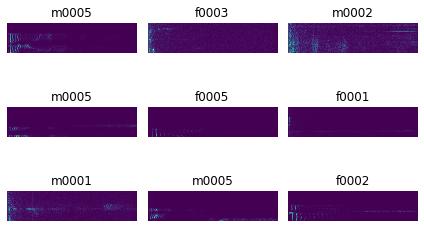

In [ ]:
let labels = batch.yb.scalars.map { sld.train.procLabel.vocab![Int($0)] }
showSpecs(batch.xb, labels: labels)

## Training

### 08_data_block method — **CRASHES THE KERNEL.**

Stolen wholesale & without thinking from `08_data_block`. 

In [ ]:
// Using CNNModel as defined in 08_data_block notebook.
func optFunc(_ model: CNNModel) -> SGD<CNNModel> { return SGD(for: model, learningRate: 0.1) }
func modelInit() -> CNNModel { return CNNModel(channelIn: 1, nOut: 10, filters: [64, 64, 128, 256]) }
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
// learner.addDelegate(learner.makeNormalize(mean: imagenetStats.mean, std: imagenetStats.std))

: 

Let's try to get our dataset stats for normalization, in case that makes a difference. I don't think it will, because `08_data_block` runs fine both with & without the normalizer.

In [ ]:
// learner.fit(1) // CRASHES KERNEL; TF-619

### 11_imagenette method  — **CRASHES THE KERNEL.**

Stolen wholesale & without thinking from `11_imagenette`. 

In [ ]:
public struct ConvLayer: Layer {
    public var bn: FABatchNorm<Float>
    public var conv: FANoBiasConv2D<Float>
    
    public init(_ cIn: Int, _ cOut: Int, ks: Int = 3, stride: Int = 1, zeroBn: Bool = false, act: Bool = true){
        bn = FABatchNorm(featureCount: cOut)
        conv = FANoBiasConv2D(cIn, cOut, ks: ks, stride: stride, activation: act ? relu : identity)
        if zeroBn { bn.scale = Tensor(zeros: [cOut]) }
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return bn(conv(input))
    }
}

In [ ]:
//A layer that you can switch off to do the identity instead
public protocol SwitchableLayer: Layer {
    associatedtype Input
    var isOn: Bool {get set}
    
    @differentiable func forward(_ input: Input) -> Input
}

public extension SwitchableLayer {
    func callAsFunction(_ input: Input) -> Input {
        return isOn ? forward(input) : input
    }

    @differentiating(callAsFunction)
    func gradForward(_ input: Input) ->
        (value: Input, pullback: (Self.Input.TangentVector) ->
            (Self.TangentVector, Self.Input.TangentVector)) {
        if isOn { return valueWithPullback(at: input) { $0($1) } }
        else { return (input, {v in return (Self.TangentVector.zero, v)}) }
    }
}

In [ ]:
public struct MaybeAvgPool2D: SwitchableLayer {
    var pool: FAAvgPool2D<Float>
    @noDerivative public var isOn = false
    
    @differentiable public func forward(_ input: TF) -> TF { return pool(input) }
    
    public init(_ sz: Int) {
        isOn = (sz > 1)
        pool = FAAvgPool2D<Float>(sz)
    }
}

In [ ]:
public struct MaybeConv: SwitchableLayer {
    var conv: ConvLayer
    @noDerivative public var isOn = false
    
    @differentiable public func forward(_ input: TF) -> TF { return conv(input) }
    
    public init(_ cIn: Int, _ cOut: Int) {
        isOn = (cIn > 1) || (cOut > 1)
        conv = ConvLayer(cIn, cOut, ks: 1, act: false)
    }
}

In [ ]:
public struct ResBlock: Layer {
    public var convs: [ConvLayer]
    public var idConv: MaybeConv
    public var pool: MaybeAvgPool2D
    
    public init(_ expansion: Int, _ ni: Int, _ nh: Int, stride: Int = 1){
        let (nf, nin) = (nh*expansion,ni*expansion)
        convs = [ConvLayer(nin, nh, ks: 1)]
        convs += (expansion==1) ? [
            ConvLayer(nh, nf, ks: 3, stride: stride, zeroBn: true, act: false)
        ] : [
            ConvLayer(nh, nh, ks: 3, stride: stride),
            ConvLayer(nh, nf, ks: 1, zeroBn: true, act: false)
        ]
        idConv = nin==nf ? MaybeConv(1,1) : MaybeConv(nin, nf)
        pool = MaybeAvgPool2D(stride)
    }
    
    @differentiable
    public func callAsFunction(_ inp: TF) -> TF {
        return relu(convs(inp) + idConv(pool(inp)))
    }
    
}

In [ ]:
func makeLayer(_ expansion: Int, _ ni: Int, _ nf: Int, _ nBlocks: Int, stride: Int) -> [ResBlock] {
    return Array(0..<nBlocks).map { ResBlock(expansion, $0==0 ? ni : nf, nf, stride: $0==0 ? stride : 1) }
}

In [ ]:
public struct XResNet: Layer {
    public var stem: [ConvLayer]
    public var maxPool = MaxPool2D<Float>(poolSize: (3,3), strides: (2,2), padding: .same)
    public var blocks: [ResBlock]
    public var pool = GlobalAvgPool2D<Float>()
    public var linear: Dense<Float>
    
    public init(_ expansion: Int, _ layers: [Int], cIn: Int = 3, cOut: Int = 1000){
        var nfs = [cIn, (cIn+1)*8, 64, 64]
        stem = Array(0..<3).map{ ConvLayer(nfs[$0], nfs[$0+1], stride: $0==0 ? 2 : 1)}
        nfs = [64/expansion,64,128,256,512]
        blocks = Array(layers.enumerated()).map { (i,l) in 
            return makeLayer(expansion, nfs[i], nfs[i+1], l, stride: i==0 ? 1 : 2)
        }.reduce([], +)
        linear = Dense(inputSize: nfs.last!*expansion, outputSize: cOut)
    }
    
    @differentiable
    public func callAsFunction(_ inp: TF) -> TF {
        return linear(pool(blocks(maxPool(stem(inp)))))
    }
    
}

In [ ]:
func xresnet18 (cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(1, [2, 2, 2, 2], cIn: cIn, cOut: cOut) }
func xresnet34 (cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(1, [3, 4, 6, 3], cIn: cIn, cOut: cOut) }
func xresnet50 (cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(4, [3, 4, 6, 3], cIn: cIn, cOut: cOut) }
func xresnet101(cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(4, [3, 4, 23, 3], cIn: cIn, cOut: cOut) }
func xresnet152(cIn: Int = 3, cOut: Int = 1000) -> XResNet { return XResNet(4, [3, 8, 36, 3], cIn: cIn, cOut: cOut) }

In [ ]:
func modelInit() -> XResNet { return xresnet34(cIn: 1, cOut: 10) }

In [ ]:
let optFunc: (XResNet) -> StatefulOptimizer<XResNet> = adamOpt(lr: 1e-3, mom: 0.9, beta: 0.99, wd: 1e-2, eps: 1e-6)

In [ ]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)

In [ ]:
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
// learner.addDelegate(learner.makeNormalize(mean: imagenetStats.mean, std: imagenetStats.std))

In [ ]:
learner.addOneCycleDelegates(1e-3, pctStart: 0.5)
// learner.fit(5) // CRASHES KERNEL; TF-619

## Fin.